In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
from cmcrameri import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
color_palette = get_palette.Petroff6().to_sn_palette()
color_palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [3]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 45, 65] # longitude min, longitude max, latitude min, latitude max
northsea = [-17, 20, 40, 70]

# Load data

In [4]:
# ERA5 analogues

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc'):
    # precip
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_tp_past2.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_tp_prst2.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    precip_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    tp = xr.concat([tmp[var] for var in precip_vars], dim="member")

    # Assign member values from 1 to 27
    tp = tp.assign_coords(member=np.arange(1, len(precip_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.Dataset({"tp": tp}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": tp.member})


    # mean sea level pressure
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_slp_past2.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_slp_prst2.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    slp_vars = sorted([var for var in tmp.data_vars if var.startswith("msl")])

    # Stack all precipitation variables along the new 'member' dimension
    msl = xr.concat([tmp[var] for var in slp_vars], dim="member")

    # Assign member values from 1 to 27
    msl = msl.assign_coords(member=np.arange(1, len(slp_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"msl": msl}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": msl.member})], compat="override")

    # 2m temperature
    tmp1 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_t2m_past2.nc').expand_dims(climate=["1950"])
    tmp2 = xr.open_mfdataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues72_t2m_prst2.nc').expand_dims(climate=["present"])

    tmp = xr.concat([tmp1, tmp2], dim="climate")

    # Find all variables that start with "unknown"
    t2m_vars = sorted([var for var in tmp.data_vars if var.startswith("unknown")])

    # Stack all precipitation variables along the new 'member' dimension
    t2m = xr.concat([tmp[var] for var in t2m_vars], dim="member")

    # Assign member values from 1 to 27
    t2m = t2m.assign_coords(member=np.arange(1, len(t2m_vars) + 1))

    # Create a new dataset with the combined variable
    era5_analogues = xr.merge([era5_analogues,
                               xr.Dataset({"t2m": t2m}, coords={"lat": tmp.lat, "lon": tmp.lon, "member": t2m.member})], compat="override")

    # Save to netcdf
    era5_analogues.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')
else:
    print('Importing data from pre-existing file')
    era5_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_analogues/analogues_72hour_mean.nc')

Importing data from pre-existing file


In [ ]:
# RACMO analogues with individual analogues, ensemble average
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogues_msl_72hour_analogues.nc'):
        # MSLP
        tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_ECEARTH__mslp__1951-1980_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["1950"])
        tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_ECEARTH__mslp__1991-2020_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["present"])
        tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_ECEARTH__mslp__2041-2070_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["future1"])
        tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_ECEARTH__mslp__2071-2100_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["future2"])


        racmo_msl = xr.concat([tmp1, tmp2, tmp3, tmp4], dim='climate').groupby('ana').mean(dim='ana').rename_dims({'ana': 'member'}).rename({"mslp": "msl"})

        # precipitation
        tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_RACMO__precip__1951-1980_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["1950"])
        tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_RACMO__precip__1991-2020_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["present"])
        tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_RACMO__precip__2041-2070_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["future1"])
        tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_Babet_A20231020_KNMI_RACMO__precip__2071-2100_3dy_ave.nc').swap_dims({'time': 'ana'}).expand_dims(climate=["future2"])

        tmp1 = tmp1.groupby('ana').mean(dim='ana')
        tmp2 = tmp2.groupby('ana').mean(dim='ana')
        tmp3 = tmp3.groupby('ana').mean(dim='ana')
        tmp4 = tmp4.groupby('ana').mean(dim='ana')

        tmp1_ = bb.data.Data.regrid_racmo(tmp1).rename_dims({'ana': 'member'}).rename({"precip": "tp"})
        tmp2_ = bb.data.Data.regrid_racmo(tmp2).rename_dims({'ana': 'member'}).rename({"precip": "tp"})
        tmp3_ = bb.data.Data.regrid_racmo(tmp3).rename_dims({'ana': 'member'}).rename({"precip": "tp"})
        tmp4_ = bb.data.Data.regrid_racmo(tmp4).rename_dims({'ana': 'member'}).rename({"precip": "tp"})
        racmo_tp = xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate")

        # Save file in two parts because lat lon are not compatible
        racmo_msl.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogues_msl_72hour_analogues.nc')
        racmo_tp.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogues_tp_72hour_analogues.nc')
else:
        print('Importing data from pre-existing file')
        racmo_msl = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogues_msl_72hour_analogues.nc')
        racmo_tp = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogues_tp_72hour_analogues.nc')

Importing data from pre-existing file


In [21]:
# PGW ens members
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc'):
    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGW+1.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_CTL.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGW+1.nc').expand_dims(climate=["future1"])
    
    tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGWdry+3.nc').expand_dims(dummy=["dry"])
    tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_slp_PGWwet+3.nc').expand_dims(dummy=["wet"])
    tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])

    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="msl")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2 , var_name="msl")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="msl")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="msl")
    pgw_ens = xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate")

    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW-1.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_CTL.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGW+1.nc').expand_dims(climate=["future1"])
    
    tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGWdry+3.nc').expand_dims(dummy=["dry"])
    tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_pr_PGWwet+3.nc').expand_dims(dummy=["wet"])
    tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])

    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="unknown")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2, var_name="unknown")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="unknown")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="unknown")
    pgw_ens = xr.merge([pgw_ens, 
                        xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate").rename({"unknown": "tp"})], 
                        compat="override")
    
    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGW-1.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_CTL.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGW+1.nc').expand_dims(climate=["future1"])
    
    tmp4dry = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGWdry+3.nc').expand_dims(dummy=["dry"])
    tmp4wet = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_t2m_PGWwet+3.nc').expand_dims(dummy=["wet"])
    tmp4 = xr.concat([tmp4dry, tmp4wet], dim="dummy").mean("dummy").squeeze().expand_dims(climate=["future2"])
    
    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="t2m")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2, var_name="t2m")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="t2m")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="t2m")
    pgw_ens = xr.merge([pgw_ens, 
                        xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate")], 
                        compat="override")

    # Save to netcdf
    pgw_ens.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc')
else:
    print('Importing data from pre-existing file')
    pgw_ens = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW_ensemble/pgw_clean_ensemble.nc')

Importing data from pre-existing file


In [17]:
# PGW
# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc'):
    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_slp_fut2.nc').expand_dims(climate=["future2"])
    

    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="unknown")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2, var_name="unknown")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="unknown")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="unknown")
    pgw = xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate").rename({"unknown": "msl"})

    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_tp_fut2.nc').expand_dims(climate=["future2"])

    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="unknown")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2, var_name="unknown")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="unknown")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="unknown")
    pgw = xr.merge([pgw,
                    xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate").rename({"unknown": "tp"})])


    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_past.nc').expand_dims(climate=["1870"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_prst.nc').expand_dims(climate=["present"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut1.nc').expand_dims(climate=["future1"])
    tmp4 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_t2m_fut2.nc').expand_dims(climate=["future2"])

    tmp1_ = bb.data.Data.clean_array_racmo(tmp1, var_name="unknown")
    tmp2_ = bb.data.Data.clean_array_racmo(tmp2, var_name="unknown")
    tmp3_ = bb.data.Data.clean_array_racmo(tmp3, var_name="unknown")
    tmp4_ = bb.data.Data.clean_array_racmo(tmp4, var_name="unknown")
    pgw = xr.merge([pgw,
                    xr.concat([tmp1_, tmp2_, tmp3_, tmp4_], dim="climate").rename({"unknown": "t2m"})])

    # Save to netcdf
    pgw.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')
else:
    print('Importing data from pre-existing file')
    pgw = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/PGW/pgw_clean.nc')

Importing data from pre-existing file


In [7]:
ifs = bb.data.Data.get_fba_ifs()

In [8]:
# # FBA IFS
# tmp = []
# base_dir='/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
# climates = ['1870', '1950', 'present', 'future1']
# for e, exp in enumerate(['pi', 'pi_1950', 'curr', 'incr']):
#     # print(os.path.join(base_dir.format(exp), '*.nc'))
#     tmp.append(xr.open_mfdataset(os.path.join(base_dir.format(exp), '*.nc'), engine='netcdf4', preprocess=preproc_ds_v2).expand_dims(climate=[climates[e]]))
# ifs = xr.concat(tmp, dim='climate')

In [9]:
# FBA ACCESS

# check if file exists
if not os.path.exists('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc'):
    # precip
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_pr_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({"pr": "tp"})

    # temperature
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_tas_ctrl.nc').expand_dims(climate=["present"])
    ds = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate")], compat="override")

    # mean sea level pressure
    tmp1 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_highGHG.nc').expand_dims(climate=["future1"])
    tmp2 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_lowGHG.nc').expand_dims(climate=["1870"])
    tmp3 = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_psl_ctrl.nc').expand_dims(climate=["present"])
    micas = xr.merge([ds, xr.concat([tmp1, tmp2, tmp3], dim="climate").rename({'psl': 'msl'})], compat="override")

    # Save to netcdf
    micas.to_netcdf('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')
else:
    print('Importing data from pre-existing file')
    micas = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/micas_clean.nc')

Importing data from pre-existing file


# Data processing

Note that the order that the map extents have to be given to the ```.sel``` function differ from dataset to dataset. You will notice immediately if something is off becausde you will end up with only nans if you do it wrong.

In [10]:
# ERA5 analogues
era5_analogues['tp'] = era5_analogues['tp'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))
era5_analogues['msl'] = era5_analogues['msl'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))/100
era5_analogues['t2m'] = era5_analogues['t2m'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))

In [25]:
# RACMO analogues
racmo_tp['tp'] = racmo_tp['tp'].sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))*3*24*3600
racmo_msl['msl'] = racmo_msl['msl'].sel(lat=slice(uk[3], uk[2]), lon=slice(uk[0], uk[1]))

In [18]:
# PGW
pgw['tp'] = (((pgw.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))*3*3600).sum(dim='time'))/1e5).sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))
pgw['msl'] = (pgw.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())/100
pgw['t2m'] = (pgw.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())

In [22]:
pgw_ens['tp'] = (((pgw_ens.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))*3*3600).sum(dim='time'))/1e5).sel(lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1]))
pgw_ens['msl'] = (pgw_ens.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())/100
pgw_ens['t2m'] = (pgw_ens.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean('time').squeeze())

In [13]:
# FBA IFS
ifs['tp'] = ((ifs.tp.sel(time='2023-10-22 00') - ifs.tp.sel(time='2023-10-19 00'))*1000).sel(latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1]))
ifs['msl'] = ifs.msl.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1])).mean(dim='time')/100
ifs['t2m'] = ifs.t2m.sel(time=slice('2023-10-19 00', '2023-10-22 00'), latitude=slice(uk[3], uk[2]), longitude=slice(uk[0], uk[1])).mean(dim='time')

In [14]:
# ACCESS MICAS
micas['tp'] = micas.tp.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).sum(dim='time')*24*3600
micas['msl'] = micas.msl.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean(dim='time')/100
micas['tas'] = micas.tas.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(uk[2], uk[3]), lon=slice(uk[0], uk[1])).mean(dim='time')

In [15]:
def is_significant(da):
    """
    Function to determine if a variable is significantly different from zero
    """
    return ((da.sel(percentile=2.5) <= 0) & (0 <= da.sel(percentile=97.5))) | ((da.sel(percentile=97.5) <= 0) & (0 <= da.sel(percentile=2.5)))

In [16]:
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/postproc/significance/'

# ERA5 analogues
tmp = xr.open_dataset(base_dir+'era5_analogues_tp_sign_map.nc')
era5_analogues_sign = tmp.groupby('climate').apply(is_significant)

# RACMO analogues

# PGW
pgw_sign = xr.open_dataset(base_dir+'pgw_tp_sign_map.nc')
pgw_sign = pgw_sign.groupby('climate').apply(is_significant)

# FBA IFS
tmp = xr.open_dataset(base_dir+'ifs_tp_sign_map.nc')
ifs_sign = tmp.groupby('climate').apply(is_significant)

# ACCESS MICAS
tmp = xr.open_dataset(base_dir+'micas_tp_sign_map.nc')
micas_sign = tmp.groupby('climate').apply(is_significant)

# Map plot

In [19]:
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args

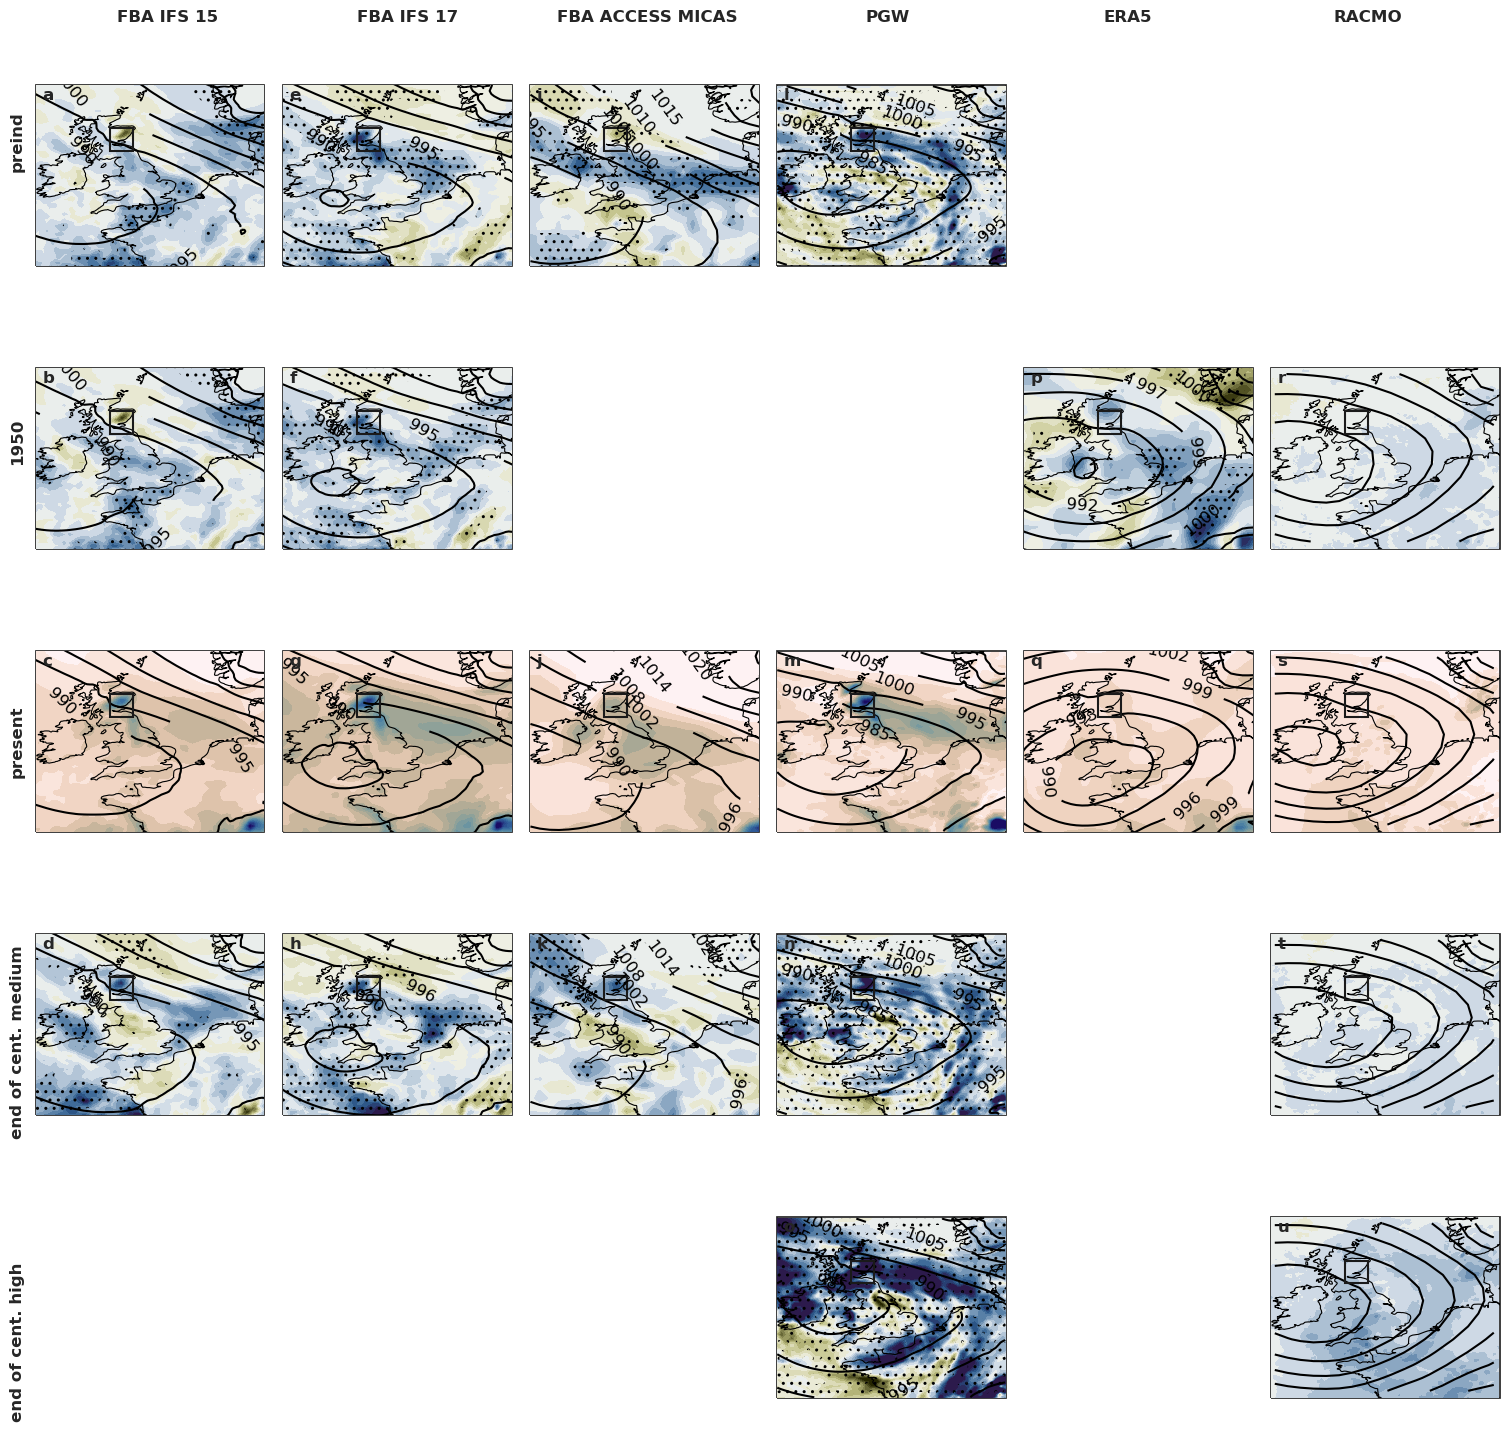

In [26]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
projection = ccrs.PlateCarree()

# difference range
pr_diff = 15
pr_full = 150

# Define column headers
column_headers = ["FBA IFS 15", "FBA IFS 17", "FBA ACCESS MICAS", "PGW", "ERA5", "RACMO"]

# FBA IFS 15 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 0], add_colorbar=False, transform=projection
)
cs = axes[0,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r, vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 0], add_colorbar=False, transform=projection
)
cs = axes[1,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 0], add_colorbar=False, transform=projection
)
cs = axes[2,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-15').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 0], add_colorbar=False, transform=projection
)
cs = axes[3,0].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-15', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,0].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-15').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[4,0].axis('off')


# FBA IFS 17 --------------

# 1870
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1870")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 1], add_colorbar=False, transform=projection
)
cs = axes[0,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1870').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1870', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# 1950
(ifs.tp.sel(climate="present") - ifs.tp.sel(climate="1950")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 1], add_colorbar=False, transform=projection
)
cs = axes[1,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='1950').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='1950', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').mean('number').squeeze().plot.contourf(
    cmap=cm.lapaz_r, vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 1], add_colorbar=False, transform=projection
)
cs = axes[2,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='present').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(ifs.tp.sel(climate="future1") - ifs.tp.sel(climate="present")).sel(inidate='2023-10-17').squeeze().mean('number').plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 1], add_colorbar=False, transform=projection
)
cs = axes[3,1].contour(ifs.longitude.values, ifs.latitude.values,ifs.msl.sel(inidate='2023-10-17', climate='future1').mean('number').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,1].contourf(ifs_sign.longitude, ifs_sign.latitude, ifs_sign.sel(climate='future1', inidate='2023-10-17').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[4,1].axis('off')

# FBA MICAS --------------

# 1870
(micas.tp.sel(climate="present") - micas.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 2], add_colorbar=False, transform=projection
)
cs = axes[0,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,2].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 2], add_colorbar=False, transform=projection
)
cs = axes[2,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(micas.tp.sel(climate="future1") - micas.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 2], add_colorbar=False, transform=projection
)
cs = axes[3,2].contour(micas.lon.values, micas.lat.values,micas.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,2].contourf(micas_sign.lon, micas_sign.lat, micas_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,2].axis('off')
axes[4,2].axis('off')

# PGW ---------------------

# 1870
(pgw_ens.tp.sel(climate="present") - pgw_ens.tp.sel(climate="1870")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[0, 3], add_colorbar=False, transform=projection
)
cs = axes[0,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='1870').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='1870').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)
# present
(pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 3], add_colorbar=False, transform=projection
)
cs = axes[2,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# future1
(pgw_ens.tp.sel(climate="future1") - pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 3], add_colorbar=False, transform=projection
)
cs = axes[3,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[3,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='future1').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)
# future2
(pgw_ens.tp.sel(climate="future2") - pgw_ens.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[4, 3], add_colorbar=False, transform=projection
)
cs = axes[4,3].contour(pgw_ens.lon.values, pgw_ens.lat.values,pgw_ens.msl.sel(climate='future2').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[4,3].contourf(pgw_sign.lon, pgw_sign.lat, pgw_sign.sel(climate='future2').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

axes[1,3].axis('off')

# ERA5 --------------------

# 1950
(era5_analogues.tp.sel(climate="present") - era5_analogues.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 4], add_colorbar=False, transform=projection
)
cs = axes[1,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[1,4].contourf(era5_analogues_sign.lon, era5_analogues_sign.lat, era5_analogues_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(era5_analogues.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 4], add_colorbar=False, transform=projection
)
cs = axes[2,4].contour(era5_analogues.lon.values, era5_analogues.lat.values,era5_analogues.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
axes[0,4].axis('off')
axes[3,4].axis('off')
axes[4,4].axis('off')

# Make ERA5 current plot stand out
# axes[2,4].outline_patch.set_linewidth(3)  # Make frame bold
# axes[2,4].outline_patch.set_edgecolor(color_palette[2])  # Set frame color to red

# RACMO -------------------

# 1950
(racmo_tp.tp.sel(climate="present") - racmo_tp.tp.sel(climate="1950")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[1, 5], add_colorbar=False, transform=projection
)
cs = axes[1,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='1950').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')
# axes[1,5].contourf(racmo_sign.lon, racmo_sign.lat, racmo_sign.sel(climate='1950').tp, alpha=0, levels=[-0.5,0.5,1],hatches=['..', None], add_colorbar=False, zorder=17, transform=projection)

# present
(racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.lapaz_r,  vmin=0, vmax=pr_full, zorder=12,
    add_labels=False,
    levels=20, ax=axes[2, 5], add_colorbar=False, transform=projection
)
cs = axes[2,5].contour(racmo_msl.lon.values, racmo_msl.lat.values,racmo_msl.msl.sel(climate='present').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future1
(racmo_tp.tp.sel(climate="future1") - racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[3, 5], add_colorbar=False, transform=projection
)
cs = axes[3,5].contour(racmo_msl.lon.values, racmo_msl.lat.values, racmo_msl.msl.sel(climate='future1').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

# future2
(racmo_tp.tp.sel(climate="future2") - racmo_tp.tp.sel(climate="present")).mean('member').squeeze().plot.contourf(
    cmap=cm.broc_r,  vmin=-1*pr_diff, vmax=pr_diff, zorder=12,
    add_labels=False,
    levels=20, ax=axes[4, 5], add_colorbar=False, transform=projection
)
cs = axes[4,5].contour(racmo_msl.lon.values, racmo_msl.lat.values, racmo_msl.msl.sel(climate='future2').mean('member').squeeze(),
                       zorder=17,
                       colors='black', transform=projection)
plt.clabel(cs, fmt='%d')

axes[0,5].axis('off')



# Figure settings ----------

labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u']
axes_with_data = [axes[0,0], axes[1,0], axes[2,0], axes[3,0], # FBA IFS 15
                  axes[0,1], axes[1,1], axes[2,1], axes[3,1], # FBA IFS 17
                  axes[0,2], axes[2,2], axes[3,2], # FBA ACCESS
                  axes[0,3], axes[2,3], axes[3,3], axes[4,3], # PGW
                  axes[1,4], axes[2,4], # ERA5
                  axes[1,5], axes[2,5], axes[3,5], axes[4,5], # RACMO

]

# Apply Cartopy settings to both axes
for ax, label in zip(axes_with_data, labels):
    ax.set_extent(uk, crs=ccrs.PlateCarree())  # Set map extent
    if ax in []:
        ax.add_feature(cfeature.COASTLINE, edgecolor='grey', linewidth=0.8, zorder = 14)  # Add land borders
    else:
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.8, zorder = 14)  # Add land borders
    ax.coastlines()  # Add coastlines
    ax.text(0.03, 0.92, label, transform=ax.transAxes, fontsize=12, fontweight="bold", zorder=20)

    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=1.5, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax.add_patch(rectangle)
    rectangle.set_zorder(17)

# Add column headers
col_locs = np.linspace(0.1, 0.9, len(column_headers))
for col_idx, col_name in enumerate(column_headers):
    fig.text(col_locs[col_idx], 0.98, col_name, fontsize=12, ha='center',  fontweight='bold')

# Define row headers
row_headers = ["preind", "1950", "present", "end of cent. medium", "end of cent. high"]

# Add row headers rotated by 90 degrees
for i, label in enumerate(row_headers):
    fig.text(0.00, 1 - (i + 0.5) / 5, label, va='center', ha='center', 
             fontsize=12, rotation=90, fontweight='bold')

plt.tight_layout()

# Save plot
plt.savefig('figures/PAPER3_map_plots.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/PAPER3_map_plots.pdf')

# Testing code for significance testing

In [ ]:
def bootstrap_sample(data, n_iterations=10):
    """Bootstrap resampling with replacement."""
    means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iterations)
    ])
    return np.percentile(means, [2.5, 97.5])  # 95% confidence interval

In [39]:
# Apply bootstrap to each grid cell along a specific dimension (e.g., 'time')
bootstrapped = xr.apply_ufunc(
    bootstrap_sample, 
    era5_analogues.tp-era5_analogues.tp.sel(climate='present'), 
    input_core_dims=[['member']],  # Modify based on your data dimensions
    vectorize=True,  # Ensures element-wise computation
    dask="parallelized",  # Enables parallel execution if data is chunked
    output_core_dims=[["percentile"]],  # Output contains percentiles
)

bootstrapped = bootstrapped.assign_coords(percentile=[2.5, 97.5])

In [40]:
# bootstrapped.sel(climate='1950', percentile=97.5).plot.contourf(levels=20)
zero_in_interval = ((bootstrapped.sel(climate='1950', percentile=2.5) <= 0) & (0 <= bootstrapped.sel(climate='1950', percentile=97.5))) | ((bootstrapped.sel(climate='1950', percentile=97.5) <= 0) & (0 <= bootstrapped.sel(climate='1950', percentile=2.5)))

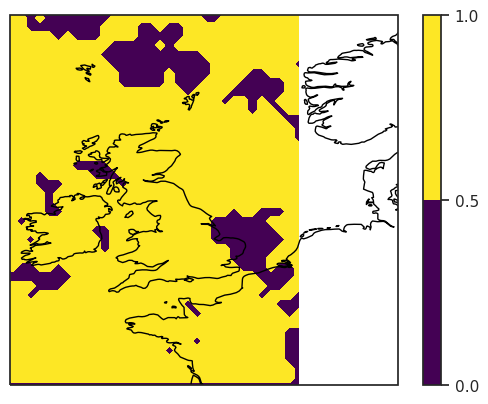

In [41]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
zero_in_interval.plot.contourf(levels=3, ax=ax, transform=ccrs.PlateCarree(), add_labels=False)
ax.coastlines()
ax.set_extent(uk, crs=ccrs.PlateCarree())

In [42]:
bootstrapped = xr.apply_ufunc(
    bootstrap_sample,
    ifs.tp-ifs.tp.sel(climate='present'),
    input_core_dims=[['number']],
    vectorize=True,
    dask="parallelized",
    output_core_dims=[["percentile"]],
    dask_gufunc_kwargs={"output_sizes": {"percentile": 2}}
    )
ifs_sign = bootstrapped.assign_coords(percentile=[2.5, 97.5])

# Significance test for Aberdeenshire box -- KS tests

In [34]:
import scipy as sc

In [35]:
aberdeen = [-4, -2, 55.5, 57.2]

In [36]:
# ERA5 analogues
print('ERA5 ANALOGUES')
aberdeen_1950 = era5_analogues.tp.sel(climate='1950').sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = era5_analogues.tp.sel(climate='present').sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1950 v present:  {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.4f}')

ERA5 ANALOGUES
1950 v present:  0.9357


In [37]:
# FBA IFS 15
print('FBA IFS 15')
aberdeen_1870 = ifs.tp.sel(climate='1870').sel(latitude=slice(aberdeen[3], aberdeen[2]), 
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_1950 = ifs.tp.sel(climate='1950').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_present = ifs.tp.sel(climate='present').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values
aberdeen_future1 = ifs.tp.sel(climate='future1').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-15').mean(['latitude', 'longitude']).values

print(f'1870 v 1950: {sc.stats.kstest(aberdeen_1870, aberdeen_1950).pvalue:.3f}')
print(f'1870 v present:  {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1950 v present: {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')

FBA IFS 15
1870 v 1950: 0.877
1870 v present:  0.728
1950 v present: 0.970
present v future1: 0.877
1870 v future1: 0.408


In [47]:
# FBA IFS 17
print('FBA IFS 17')
aberdeen_1870 = ifs.tp.sel(climate='1870').sel(latitude=slice(aberdeen[3], aberdeen[2]), 
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_1950 = ifs.tp.sel(climate='1950').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_present = ifs.tp.sel(climate='present').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values
aberdeen_future1 = ifs.tp.sel(climate='future1').sel(latitude=slice(aberdeen[3], aberdeen[2]),
                                               longitude=slice(aberdeen[0], aberdeen[1]), 
                                               inidate='2023-10-17').mean(['latitude', 'longitude']).values

print(f'1870 v 1950: {sc.stats.kstest(aberdeen_1870, aberdeen_1950).pvalue:.3f}')
print(f'1870 v present:  {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1950 v present: {sc.stats.kstest(aberdeen_1950, aberdeen_present).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')

FBA IFS 17
1870 v 1950: 0.717
1870 v present:  0.039
1950 v present: 0.272
present v future1: 0.039
1870 v future1: 0.001


In [38]:
# FBA MICAS
aberdeen_1870 = micas.tp.sel(climate='1870',
                             lat=slice(aberdeen[2], aberdeen[3]),
                             lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = micas.tp.sel(climate='present',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future1 = micas.tp.sel(climate='future1',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1870 v present: {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')

1870 v present: 0.654
1870 v future1: 0.654
present v future1: 0.654


In [39]:
# PGW
aberdeen_1870 = pgw_ens.tp.sel(climate='1870',
                             lat=slice(aberdeen[2], aberdeen[3]),
                             lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_present = pgw_ens.tp.sel(climate='present',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values
aberdeen_future1 = pgw_ens.tp.sel(climate='future1',
                                lat=slice(aberdeen[2], aberdeen[3]),
                                lon=slice(aberdeen[0], aberdeen[1])).mean(['lat', 'lon']).values

print(f'1870 v present: {sc.stats.kstest(aberdeen_1870, aberdeen_present).pvalue:.3f}')
print(f'1870 v future1: {sc.stats.kstest(aberdeen_1870, aberdeen_future1).pvalue:.3f}')
print(f'present v future1: {sc.stats.kstest(aberdeen_present, aberdeen_future1).pvalue:.3f}')

1870 v present: 0.771
1870 v future1: 1.000
present v future1: 1.000


In [18]:
aberdeen = [-4, -2, 55.5, 57.5]

def bootstrap_sample(data, n_iterations=100):
    """Bootstrap resampling with replacement.""" 
    means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iterations)
    ])
    return np.percentile(means, [2.5, 97.5])  # 95% confidence interval


In [19]:
def calc_precip_scaling(t2m, tp, latitude_name = 'latitude', longitude_name = 'longitude', climate='1950'):
    """
    Function to calculate the scaling of precipitation with temperature. Averaging over area first

    Parameters
    ----------
    t2m : xarray DataArray
        Temperature data for the region of interest. Needs to have dimension climate.
    tp : xarray DataArray
        Precipitation data for the region of interest. Needs to have dimension climate.
    latitude_name : str
        Name of the latitude dimension in the DataArray. 
    longitude_name : str
        Name of the longitude dimension in the DataArray.
    climate : str, optional
        Climate scenario to compare against. The default is '1950'.

    Returns
    -------
    scaling_factor : xarray DataArray
        Scaling factor for precipitation with temperature.
    """
    
    # Calculate the mean temperature and precipitation
    mean_t2m = t2m.mean(dim=[latitude_name, longitude_name])
    mean_tp = tp.mean(dim=[latitude_name, longitude_name])

    # Calculate change in temperature over Aberdeenshire
    t2m_present = mean_t2m.sel(climate='present')
    t2m_climate = mean_t2m.sel(climate=climate)
    delta_t2m = t2m_present - t2m_climate

    # Calculate fractional precipitation change
    tp_present = mean_tp.sel(climate='present')
    tp_climate = mean_tp.sel(climate=climate)
    delta_tp = (tp_present - tp_climate)/tp_present

    # Calculate the scaling factor
    scaling_factor = delta_tp / delta_t2m
    return scaling_factor


In [ ]:
# European temperatures
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print(scaling_factors)

{'1870': array([0.00195692, 0.10936347], dtype=float32), '1950': array([-0.5045801 ,  0.09581669], dtype=float32), 'future1': array([18.029657  ,  0.12654911], dtype=float32)}


In [ ]:
# Aberdeenshire temperatures
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print(scaling_factors)

{'1870': array([5.401507  , 0.03213355], dtype=float32), '1950': array([-0.9181732 ,  0.05896278], dtype=float32), 'future1': array([0.95739   , 0.05651156], dtype=float32)}


In [ ]:
# test function
just_one_climate = False
if just_one_climate:
    calc_precip_scaling(
        ifs.t2m.sel(latitude=slice(aberdeen[3], aberdeen[2]),longitude=slice(aberdeen[0], aberdeen[1])), 
        ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),longitude=slice(aberdeen[0], aberdeen[1])),
        climate='future1'
        ).sel(inidate='2023-10-17').mean('number').compute()
else:
    # Slice latitude and longitude just once
    region_t2m = ifs.t2m.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                            longitude=slice(aberdeen[0], aberdeen[1]))
    region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                        longitude=slice(aberdeen[0], aberdeen[1]))

    # Define list of climates to compare against 'present'
    climates = ['1870', '1950', 'future1']

    # Use dictionary comprehension, compute after loop to maximize parallelism
    scaling_factors = {
        climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number')
        for climate in climates
    }

    # Compute all at once (parallelized if using Dask)
    from dask import compute
    computed_values = compute(*scaling_factors.values())
    scaling_factors = dict(zip(climates, computed_values))

    print(scaling_factors)

KeyError: 'no index found for coordinate climate'

In [ ]:
# test function
test = False
if test:
      # IFS precip scaling
      climate = 'future1'
      inidate = '2023-10-17'

      # area average first
      ifs_aberdeen = ifs.get(['tp', 't2m']).sel(latitude=slice(aberdeen[3], aberdeen[2]),longitude=slice(aberdeen[0], aberdeen[1])).mean(dim=['latitude', 'longitude'])
      delta_tp = (ifs_aberdeen.tp - ifs_aberdeen.tp.sel(climate='present'))/ifs_aberdeen.tp.sel(climate='present')
      dt2m = (ifs_aberdeen.t2m - ifs_aberdeen.t2m.sel(climate='present'))
      scaling = delta_tp/dt2m
      print('Area average first', 
            scaling.sel(climate=climate, inidate=inidate).mean(dim='number').values) # should be 0.0565 for 2023-10-17 and future1, same as in function